# Calculate synergy in isoprenol production
Use the first 2 DBTL cycles to identify combinations of gRNA that were unexpectedly high or low producers based on additivity.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import TheilSenRegressor
import re

In [2]:
try: 
    from adjustText import adjust_text
except ModuleNotFoundError:
    !pip install adjustText 
    from adjustText import adjust_text 

In [3]:
dbtl1_filter = pd.read_csv('../dbtl1_figures_and_analysis_filter/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col = 0)
data = pd.read_pickle('../dbtl1_figures_and_analysis/dbtl0_dbtl1_isoprenol_processed_df.pkl')

In [4]:
data.head()

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,1,Control-R1
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,2,Control-R2
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,3,Control-R3
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,4,Control-R4
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,5,Control-R5


In [5]:
data.columns[:20]

Index(['Line Name', 'Line Description', 'Units', 'isoprenol', 'rep',
       'line_name_norep', 'nt_string', 'cycle', 'is_control',
       'sorted_gene_list', 'number_of_grna', 'dbtl1_filter', 'gRNA_1',
       'gRNA_2', 'gRNA_3', 'gRNA_4', 'PP_0001', 'PP_0103', 'PP_0104',
       'PP_0105'],
      dtype='object')

In [6]:
data = data[data['pass_to_art'] == 1]

## Calculate synergy for each 2x gRNA

In [7]:
double_strains = data.loc[data['number_of_grna'] == 2, 'line_name_norep'].unique()
triple_strains = data.loc[data['number_of_grna'] == 3, 'line_name_norep'].unique()

grna1_list = []
grna2_list = []
grna3_list = []
titer1_list = []
titer2_list = []
titer3_list = []
titercombo_list = []

for s in triple_strains:
    s_idx = (data['line_name_norep'] == s)
    grna_list = re.findall('PP_[0-9]{4}', s)
    grna1_list.append(grna_list[0])
    grna2_list.append(grna_list[1])
    grna3_list.append(grna_list[2])
    titer1_list.append(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[0]),
            'isoprenol'
        ].mean()
    )
    
    titer2_list.append(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[1]),
            'isoprenol'
        ].mean()
    )
    titer3_list.append(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[2]),
            'isoprenol'
        ].mean()
    )
    titercombo_list.append(
        data.loc[
            (data['cycle'] == 1) &
            (data['line_name_norep'] == s),
            'isoprenol'
        ].mean()
    )
    
    titer1_len = len(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[0]),
            'isoprenol'
        ]
    )
    titer2_len = len(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[1]),
            'isoprenol'
        ]
    )
    titercombo_len = len(
        data.loc[
            (data['cycle'] == 1) &
            (data['line_name_norep'] == s),
            'isoprenol'
        ]
    )
    print(f'S = {s}\nFound N = {titer1_len} entries for titer {grna_list[0]}\nFound N = {titer2_len} entries for titer {grna_list[1]}\nfound N = {titercombo_len} entries for titer {s}')
    if titer1_len > 3:
        print(data.loc[(data['line_name_norep'] == grna_list[0]), ['line_name_norep', 'Line Name']])
    if titer2_len > 3:
        print(data.loc[(data['line_name_norep'] == grna_list[1]), ['line_name_norep', 'Line Name']])
    if titercombo_len > 3:
        print(data.loc[(data['line_name_norep'] == s), ['line_name_norep', 'Line Name']])
        
syn_df_triple = pd.DataFrame.from_dict(
    {
        's': triple_strains,
        'grna1': grna1_list,
        'grna2': grna2_list,
        'grna3': grna3_list,
        'titer1': titer1_list,
        'titer2': titer2_list,
        'titer3': titer3_list,
        'titer_combo': titercombo_list
    }
)

S = PP_0226_PP_0897_PP_5288
Found N = 3 entries for titer PP_0226
Found N = 3 entries for titer PP_0897
found N = 3 entries for titer PP_0226_PP_0897_PP_5288
S = PP_2213_PP_2471_PP_4266
Found N = 3 entries for titer PP_2213
Found N = 3 entries for titer PP_2471
found N = 3 entries for titer PP_2213_PP_2471_PP_4266
S = PP_3123_PP_4862_PP_5186
Found N = 3 entries for titer PP_3123
Found N = 3 entries for titer PP_4862
found N = 3 entries for titer PP_3123_PP_4862_PP_5186
S = PP_4189_PP_4550_PP_4862
Found N = 3 entries for titer PP_4189
Found N = 3 entries for titer PP_4550
found N = 3 entries for titer PP_4189_PP_4550_PP_4862
S = PP_0813_PP_4549_PP_5288
Found N = 3 entries for titer PP_0813
Found N = 3 entries for titer PP_4549
found N = 3 entries for titer PP_0813_PP_4549_PP_5288
S = PP_0999_PP_3578_PP_5186
Found N = 3 entries for titer PP_0999
Found N = 3 entries for titer PP_3578
found N = 3 entries for titer PP_0999_PP_3578_PP_5186
S = PP_2137_PP_4011_PP_4120
Found N = 3 entries for 

In [8]:
double_strains = data.loc[data['number_of_grna'] == 2, 'line_name_norep'].unique()
triple_strains = data.loc[data['number_of_grna'] == 3, 'line_name_norep'].unique()

grna1_list = []
grna2_list = []
titer1_list = []
titer2_list = []
titercombo_list = []

for s in double_strains:
    s_idx = (data['line_name_norep'] == s)
    grna_list = re.findall('PP_[0-9]{4}', s)
    grna1_list.append(grna_list[0])
    grna2_list.append(grna_list[1])
    
    titer1_list.append(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[0]),
            'isoprenol'
        ].mean()
    )
    
    titer2_list.append(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[1]),
            'isoprenol'
        ].mean()
    )
    titercombo_list.append(
        data.loc[
            (data['cycle'] == 1) &
            (data['line_name_norep'] == s),
            'isoprenol'
        ].mean()
    )
    
    titer1_len = len(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[0]),
            'isoprenol'
        ]
    )
    titer2_len = len(
        data.loc[
            (data['cycle'] == 0) &
            (data['line_name_norep'] == grna_list[1]),
            'isoprenol'
        ]
    )
    titercombo_len = len(
        data.loc[
            (data['cycle'] == 1) &
            (data['line_name_norep'] == s),
            'isoprenol'
        ]
    )
    print(f'S = {s}\nFound N = {titer1_len} entries for titer {grna_list[0]}\nFound N = {titer2_len} entries for titer {grna_list[1]}\nfound N = {titercombo_len} entries for titer {s}')
    if titer1_len > 3:
        print(data.loc[(data['line_name_norep'] == grna_list[0]), ['line_name_norep', 'Line Name']])
    if titer2_len > 3:
        print(data.loc[(data['line_name_norep'] == grna_list[1]), ['line_name_norep', 'Line Name']])
    if titercombo_len > 3:
        print(data.loc[(data['line_name_norep'] == s), ['line_name_norep', 'Line Name']])
        
syn_df_double = pd.DataFrame.from_dict(
    {
        's': double_strains,
        'grna1': grna1_list,
        'grna2': grna2_list,
        'titer1': titer1_list,
        'titer2': titer2_list,
        'titer_combo': titercombo_list
    }
)

S = PP_0814_PP_5288
Found N = 3 entries for titer PP_0814
Found N = 3 entries for titer PP_5288
found N = 3 entries for titer PP_0814_PP_5288
S = PP_0658_PP_2136
Found N = 3 entries for titer PP_0658
Found N = 3 entries for titer PP_2136
found N = 3 entries for titer PP_0658_PP_2136
S = PP_4122_PP_4188
Found N = 3 entries for titer PP_4122
Found N = 3 entries for titer PP_4188
found N = 3 entries for titer PP_4122_PP_4188
S = PP_0368_PP_0597
Found N = 3 entries for titer PP_0368
Found N = 3 entries for titer PP_0597
found N = 3 entries for titer PP_0368_PP_0597
S = PP_0528_PP_5288
Found N = 3 entries for titer PP_0528
Found N = 3 entries for titer PP_5288
found N = 3 entries for titer PP_0528_PP_5288
S = PP_0813_PP_4120
Found N = 3 entries for titer PP_0813
Found N = 3 entries for titer PP_4120
found N = 3 entries for titer PP_0813_PP_4120
S = PP_1620_PP_4116
Found N = 3 entries for titer PP_1620
Found N = 3 entries for titer PP_4116
found N = 3 entries for titer PP_1620_PP_4116
S = PP

In [24]:
syn_df_double['additive'] = syn_df_double['titer1'] + syn_df_double['titer2']
syn_df_double['delta_additive'] = syn_df_double['titer_combo'] - syn_df_double['additive']
syn_df_double['max_single'] = np.max(syn_df_double[['titer1', 'titer2']], axis = 1)

syn_df_double['delta_max'] = syn_df_double['titer_combo'] - syn_df_double['max_single']

syn_df_triple['additive'] = syn_df_triple['titer1'] + syn_df_triple['titer2'] + syn_df_triple['titer3']
syn_df_triple['delta_additive'] = syn_df_triple['titer_combo'] - syn_df_triple['additive']


In [25]:
syn_df_double.sort_values('delta_max')

,s,grna1,grna2,titer1,titer2,titer_combo,additive,epistasis,y1r,y2r,eps,delta_additive,delta_max,max_single
5,PP_0813_PP_4120,PP_0813,PP_4120,323.670443,242.994757,254.292367,566.665200,-312.372833,160.050019,79.374332,-0.011709,-312.372833,-69.378077,323.670443
12,PP_3365_PP_3754,PP_3365,PP_3754,172.992533,176.574823,134.325167,349.567357,-215.242190,9.372109,12.954399,-0.425185,-215.242190,-42.249657,176.574823
9,PP_0812_PP_2095,PP_0812,PP_2095,243.918823,131.855603,211.020500,375.774427,-164.753927,80.298399,-31.764821,0.000444,-164.753927,-32.898323,243.918823
4,PP_0528_PP_5288,PP_0528,PP_5288,393.699713,162.855487,377.932600,556.555200,-178.622600,230.079289,-0.764938,0.085241,-178.622600,-15.767113,393.699713
6,PP_1620_PP_4116,PP_1620,PP_4116,86.728683,143.072067,132.081700,229.800750,-97.719050,-76.891741,-20.548358,0.041710,-97.719050,-10.990367,143.072067
1,PP_0658_PP_2136,PP_0658,PP_2136,130.084000,234.133267,227.645200,364.217267,-136.572067,-33.536424,70.512842,-0.011438,-136.572067,-6.488067,234.133267
0,PP_0814_PP_5288,PP_0814,PP_5288,312.395913,162.855487,322.208767,475.251400,-153.042633,148.775489,-0.764938,-0.092947,-153.042633,9.812853,312.395913
10,PP_0437_PP_4116,PP_0437,PP_4116,225.591353,143.072067,236.085933,368.663420,-132.577487,61.970929,-20.548358,-0.024378,-132.577487,10.494580,225.591353
8,PP_0814_PP_4862,PP_0814,PP_4862,312.395913,143.944090,324.816317,456.340003,-131.523687,148.775489,-19.676334,-0.010964,-131.523687,12.420403,312.395913
2,PP_4122_PP_4188,PP_4122,PP_4188,172.505710,209.970753,227.343533,382.476463,-155.132930,8.885286,46.350329,0.020609,-155.132930,17.372780,209.970753


In [28]:
syn_df_double[['s', 'titer1', 'titer2', 'titer_combo', 'delta_max']].sort_values('delta_max')

,s,titer1,titer2,titer_combo,delta_max
5,PP_0813_PP_4120,323.670443,242.994757,254.292367,-69.378077
12,PP_3365_PP_3754,172.992533,176.574823,134.325167,-42.249657
9,PP_0812_PP_2095,243.918823,131.855603,211.020500,-32.898323
4,PP_0528_PP_5288,393.699713,162.855487,377.932600,-15.767113
6,PP_1620_PP_4116,86.728683,143.072067,132.081700,-10.990367
1,PP_0658_PP_2136,130.084000,234.133267,227.645200,-6.488067
0,PP_0814_PP_5288,312.395913,162.855487,322.208767,9.812853
10,PP_0437_PP_4116,225.591353,143.072067,236.085933,10.494580
8,PP_0814_PP_4862,312.395913,143.944090,324.816317,12.420403
2,PP_4122_PP_4188,172.505710,209.970753,227.343533,17.372780


In [11]:
syn_df_triple.sort_values('epistasis')

,s,grna1,grna2,grna3,titer1,titer2,titer3,titer_combo,additive,epistasis
8,PP_0437_PP_0528_PP_3578,PP_0437,PP_0528,PP_3578,225.591353,393.699713,167.820153,292.983800,787.111220,-494.127420
4,PP_0813_PP_4549_PP_5288,PP_0813,PP_4549,PP_5288,323.670443,201.787890,162.855487,255.495467,688.313820,-432.818353
6,PP_2137_PP_4011_PP_4120,PP_2137,PP_4011,PP_4120,188.364667,161.546977,242.994757,191.026400,592.906400,-401.880000
12,PP_0658_PP_0815_PP_4187,PP_0658,PP_0815,PP_4187,130.084000,258.977800,143.804070,186.236000,532.865870,-346.629870
7,PP_2471_PP_3754_PP_4667,PP_2471,PP_3754,PP_4667,187.663177,176.574823,178.382267,202.130700,542.620267,-340.489567
13,PP_0774_PP_2213_PP_5288,PP_0774,PP_2213,PP_5288,142.327820,188.377357,162.855487,154.500267,493.560663,-339.060397
11,PP_0226_PP_2339_PP_3365,PP_0226,PP_2339,PP_3365,139.635497,152.381423,172.992533,132.506533,465.009453,-332.502920
10,PP_0226_PP_0437_PP_0751,PP_0226,PP_0437,PP_0751,139.635497,225.591353,316.538177,351.624300,681.765027,-330.140727
1,PP_2213_PP_2471_PP_4266,PP_2213,PP_2471,PP_4266,188.377357,187.663177,129.712563,187.568067,505.753097,-318.185030
0,PP_0226_PP_0897_PP_5288,PP_0226,PP_0897,PP_5288,139.635497,142.679290,162.855487,132.559100,445.170273,-312.611173


Text(0.5, 1.0, 'epistasis in 2x gRNA')

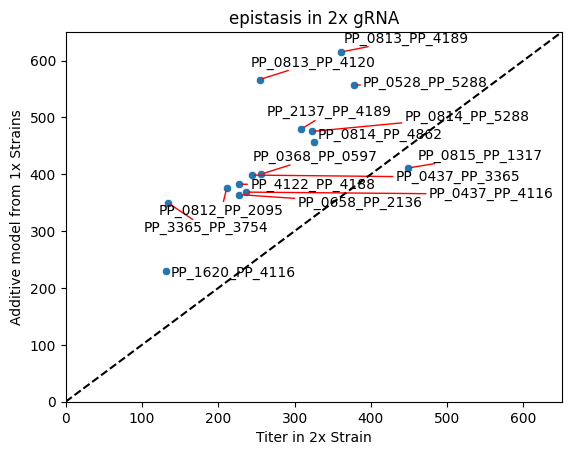

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(
    data = syn_df_double,
    x = 'titer_combo',
    y = 'additive',
)
ax.axline((100,100), slope = 1, linestyle = '--', c = 'k')
ax.set_xlim([0, 650])
ax.set_ylim([0, 650])
texts = []
for idx, srs in syn_df_double.iterrows():
    text = plt.text(srs['titer_combo'], srs['additive'], srs['s'], fontsize = 10)
    texts.append(text)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

ax.set_xlabel('Titer in 2x Strain')
ax.set_ylabel('Additive model from 1x Strains')
ax.set_title('epistasis in 2x gRNA')

Text(0.5, 1.0, 'epistasis in 2x gRNA')

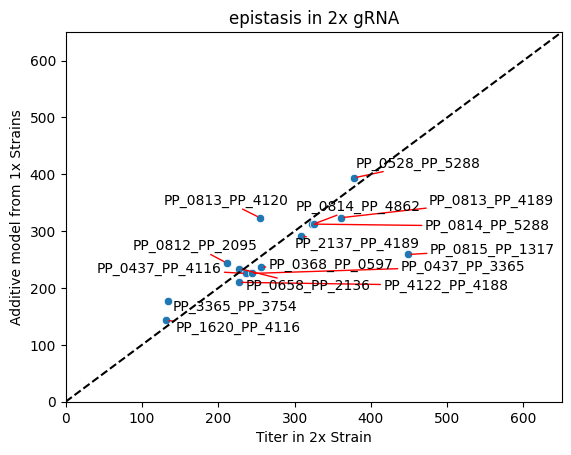

In [27]:
fig, ax = plt.subplots()
sns.scatterplot(
    data = syn_df_double,
    x = 'titer_combo',
    y = 'max_single',
)
ax.axline((100,100), slope = 1, linestyle = '--', c = 'k')
ax.set_xlim([0, 650])
ax.set_ylim([0, 650])
texts = []
for idx, srs in syn_df_double.iterrows():
    text = plt.text(srs['titer_combo'], srs['max_single'], srs['s'], fontsize = 10)
    texts.append(text)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

ax.set_xlabel('Titer in 2x Strain')
ax.set_ylabel('Additive model from 1x Strains')
ax.set_title('epistasis in 2x gRNA')

Text(0.5, 1.0, 'epistasis in 3x gRNA')

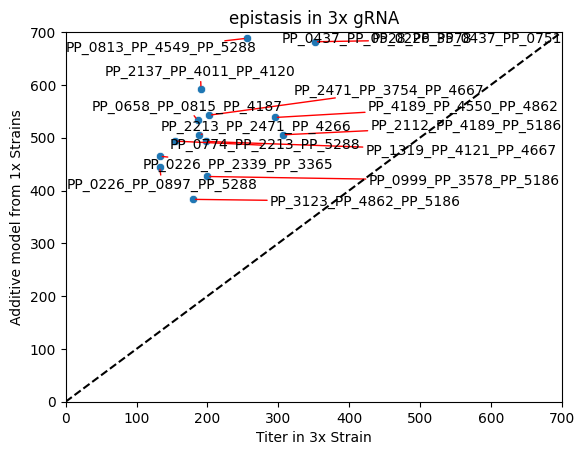

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(
    data = syn_df_triple,
    x = 'titer_combo',
    y = 'additive',
)
ax.axline((100,100), slope = 1, linestyle = '--', c = 'k')
ax.set_xlim([0, 700])
ax.set_ylim([0, 700])
texts = []
for idx, srs in syn_df_triple.iterrows():
    text = plt.text(srs['titer_combo'], srs['additive'], srs['s'], fontsize = 10)
    texts.append(text)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))
ax.set_xlabel('Titer in 3x Strain')
ax.set_ylabel('Additive model from 1x Strains')
ax.set_title('epistasis in 3x gRNA')

In [14]:
'PP_0814_PP_5288'.split('_PP')

['PP_0814', '_5288']

In [15]:
data

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,1,Control-R1
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,2,Control-R2
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,3,Control-R3
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,4,Control-R4
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,5,Control-R5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,Control_P4-R2,DBTL1_P4_040,mg/L,179.50750,11,Control,None,1,True,[],...,0,0,0,0,0,0,False,1,29,Control-R29
590,PP_0813_PP_4189-R3,DBTL1_P4_042,mg/L,371.16870,3,PP_0813_PP_4189,None,1,False,"[PP_0813, PP_4189]",...,0,0,0,0,0,0,True,1,3,PP_0813_PP_4189-R3
592,PP_0437_PP_3365-R3,DBTL1_P4_044,mg/L,247.03410,3,PP_0437_PP_3365,None,1,False,"[PP_0437, PP_3365]",...,0,0,0,0,0,0,True,1,3,PP_0437_PP_3365-R3
593,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,mg/L,208.59250,3,PP_1319_PP_4121_PP_4667,None,1,False,"[PP_1319, PP_4121, PP_4667]",...,0,0,0,0,0,0,True,1,3,PP_1319_PP_4121_PP_4667-R3


In [18]:
control_titer = data.loc[data['is_control'], 'isoprenol'].mean()
syn_df_double['y1r'] = syn_df_double['titer1']-control_titer
syn_df_double['y2r'] = syn_df_double['titer2']-control_titer
syn_df_double['eps'] = (
    (syn_df_double['titer_combo'] - control_titer - syn_df_double['y1r'] - syn_df_double['y2r'])/
    (syn_df_double['y1r'] * syn_df_double['y2r'])
)
syn_df_double.sort_values('eps')

    

,s,grna1,grna2,titer1,titer2,titer_combo,additive,epistasis,y1r,y2r,eps
12,PP_3365_PP_3754,PP_3365,PP_3754,172.992533,176.574823,134.325167,349.567357,-215.242190,9.372109,12.954399,-0.425185
11,PP_0815_PP_1317,PP_0815,PP_1317,258.977800,152.125047,448.916800,411.102847,37.813953,95.357376,-11.495378,-0.183762
0,PP_0814_PP_5288,PP_0814,PP_5288,312.395913,162.855487,322.208767,475.251400,-153.042633,148.775489,-0.764938,-0.092947
10,PP_0437_PP_4116,PP_0437,PP_4116,225.591353,143.072067,236.085933,368.663420,-132.577487,61.970929,-20.548358,-0.024378
5,PP_0813_PP_4120,PP_0813,PP_4120,323.670443,242.994757,254.292367,566.665200,-312.372833,160.050019,79.374332,-0.011709
1,PP_0658_PP_2136,PP_0658,PP_2136,130.084000,234.133267,227.645200,364.217267,-136.572067,-33.536424,70.512842,-0.011438
8,PP_0814_PP_4862,PP_0814,PP_4862,312.395913,143.944090,324.816317,456.340003,-131.523687,148.775489,-19.676334,-0.010964
13,PP_0813_PP_4189,PP_0813,PP_4189,323.670443,291.395380,361.368367,615.065823,-253.697457,160.050019,127.774956,-0.004405
7,PP_2137_PP_4189,PP_2137,PP_4189,188.364667,291.395380,308.928767,479.760047,-170.831280,24.744242,127.774956,-0.002281
9,PP_0812_PP_2095,PP_0812,PP_2095,243.918823,131.855603,211.020500,375.774427,-164.753927,80.298399,-31.764821,0.000444


<Axes: xlabel='epistasis', ylabel='eps'>

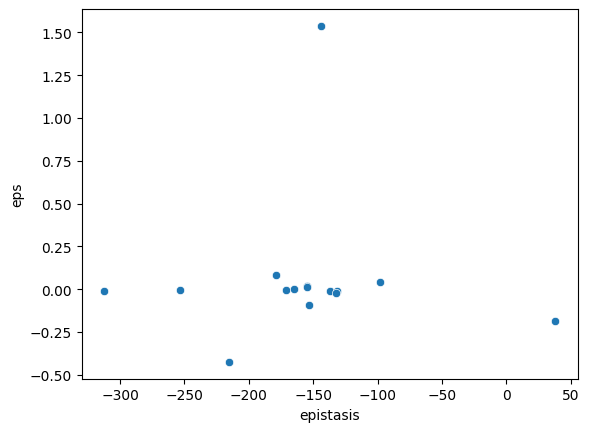

In [19]:
sns.scatterplot(syn_df_double, x = 'epistasis', y = 'eps')